# Classifying Data Exploration

## Understand the Code 
> Review the dataset documentation to understand the fetures and lables

A brain tumor is a collection, or mass of abnormal cells in the brain. The sckull, which encloses your brain, is very rigid. Any growth inside such a restricted space will cause problems. Brain tumors can be cancerous (malignant) or noncancerous (benign). When benign or malignant tumors grow, they can cause the pressure inside the skull to increase. This will cause brain damage, and probabily life-threatening

Classification: the dataset is the combination of three datasets: figshare, SARTAJ dataset, Br35H. They contain 7023 images of human brain MRI images which are classified into 4 classes: giloma, meningioma, no tumor and pituitary.

Segmentation: the dataset is the combination of three datasets from BraTS competition. The images are all available as NIfTI files and describes native T1 and post-contrast T1-weighted (T1Gd) T2-weighted and T2 fluid attenuated inversion recovery (T2-FLAIR), and were acquired with different clinical protocols and various scanner from 19 institutions, mentioned as data contributors here. All the imaging datasets have been segmented manually, by one to four raters, following the same annotation protocol, and their annotations were approved by experienced neuro-radiologists. Annotations comprise the GD-enhancing tumor, the peritumoral edema, and the necrotic and non-enhancing tumor core, as described both in the BraTS TMI paper and in the latest BraTS summarizing paper. The data are distributed after the pre-processing, coregistered to the same anatomical template, interpolated to the same resolution adn skull-stripped. 

> Verify if there are any missing values or outliers

No missing values and outliers.

## Visualization:
> Create visualizations to explore the distribution of data, such as histograms, box plots, or violin plots for numerical features.



> Use scatter plots or pair plots to analyze relationships between different features.

! Draw a bar plot for classification

> Visualize class distributions to understand the balance of your dataset.

> Check if there is a significant class imbalance in your dataset. If so, consider strategies to address it, such as oversampling, undersampling, or using different evaluation metrics.


In [ ]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models 

## Preprocess the dataset

In [3]:
IMAGE_SIZE, BATCH_SIZE, CHANNELS  = 128, 32, 3

data = tf.keras.preprocessing.image_dataset_from_directory('../data/classifyData/Training',
                                                          image_size = (IMAGE_SIZE, IMAGE_SIZE),
                                                          batch_size = BATCH_SIZE
                                                          )

Found 5712 files belonging to 4 classes.


2024-01-11 13:06:40.086050: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
cls_names = data.class_names
print(cls_names)
for image_batch, labels_batch in data.take(1):
    print(image_batch.shape)
    print(labels_batch)

['glioma', 'meningioma', 'notumor', 'pituitary']
(32, 128, 128, 3)
tf.Tensor([2 0 0 1 1 2 1 1 0 2 1 0 2 2 3 2 0 2 3 3 3 3 3 0 1 3 2 3 0 0 0 2], shape=(32,), dtype=int32)


## Visuaization

## Image Data Exploration:
> If your data includes images, visualize some sample images from each class.

In the process of exploring image data for the classification model, I found the step of visualizing sample images from each class to be very insightful. It provided a visual understanding of the dataset also helped in identifying potential variation within each class.
> Check for variations in image quality, resolution, and lighting conditions.

Examining the images allowed me to observe differences in image quality, resolution, and lighting conditions across various classes. This was crucial in understanding the inherent challenges and variations present in the dataset. It became apparent that some classes had images with varying level of clarity, while others exhibited differences in lighting conditions that could impact model performance. 
> Augment the images if necessary to increase the diversity of your dataset.

To enhance the diversity of the dataset, I decided to augment the images. Augementation techniques, such as rotation, flipping, and changes in brightness, were applied to generate additional variations within each class. The step aimed to ensure that the model would be more robust and capable of handling different scenarios. 

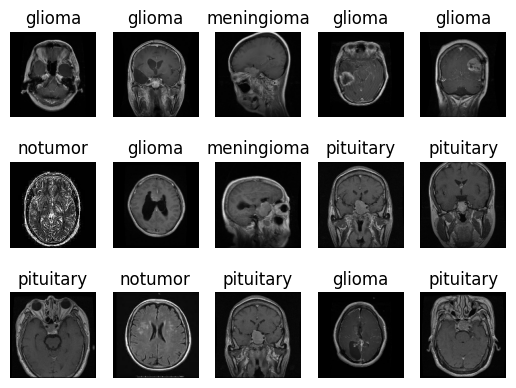

In [5]:
for image_batch, labels_batch in data.take(1):
    for i in range(15):
        ax = plt.subplot(3,5, i+1)
        plt.axis('off')
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(cls_names[labels_batch[i]], fontsize=12)
plt.savefig('./images/Data Exploration/Classification_visualization.png', dpi=400)

# Segementation Data Exploration

In [8]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import glob
import PIL
from PIL import Image, ImageOps
import shutil
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  

In [11]:
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
import gif_your_nifti.core as gif2nif

In [12]:
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers.experimental import preprocessing
np.set_printoptions(precision=3, suppress=True)

In [13]:
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 # first slice of volume that we will include

## Image Data Exploration:
> If your data includes images, visualize some sample images from each class.

In the process of exploring image data for the classification model, I found the step of visualizing sample images from each class to be very insightful. It provided a visual understanding of the dataset also helped in identifying potential variation within each class.
> Check for variations in image quality, resolution, and lighting conditions.

Examining the images allowed me to observe differences in image quality, resolution, and lighting conditions across various classes. This was crucial in understanding the inherent challenges and variations present in the dataset. It became apparent that some classes had images with varying level of clarity, while others exhibited differences in lighting conditions that could impact model performance. 
> Augment the images if necessary to increase the diversity of your dataset.

To enhance the diversity of the dataset, I decided to augment the images. Augementation techniques, such as rotation, flipping, and changes in brightness, were applied to generate additional variations within each class. The step aimed to ensure that the model would be more robust and capable of handling different scenarios. 

Text(0.5, 1.0, 'Mask')

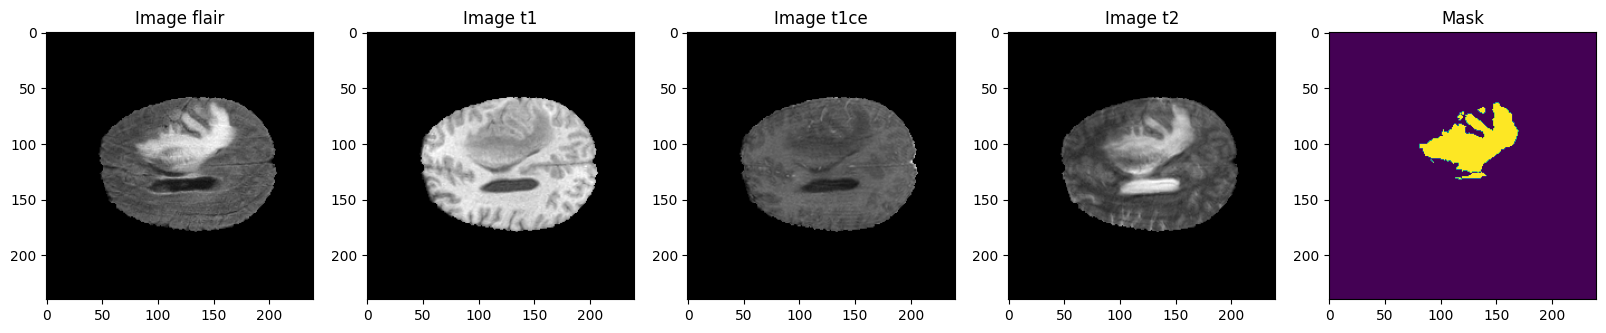

In [14]:
TRAIN_DATASET_PATH = '../data/segData/2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')


## Dimensionality Reduction:

Exploring dimensionality reduction techniques, particularly employing Principal Component Analysis (PCA), proved to be a crucial step in our data analysis pipeline. The objective was to visualize high-dimensional data in lower dimensions, aiding in the identification of patterns and clusters within the dataset.

PCA allowed us to effectively reduce the number of features while retaining the essential information. The visual representation of data in lower dimensions provided valuable insights into the underlying structure of the dataset. By projecting the data onto a lower-dimensional space, we could discern patterns and relationships that might not have been apparent in the original high-dimensional space.

Observing the distribution of data points in the reduced dimensions facilitated the identification of clusters and patterns that could be indicative of intrinsic groupings within the data. This information was instrumental in guiding subsequent steps in our analysis, including clustering algorithms and classification models.

In summary, leveraging dimensionality reduction techniques like PCA significantly enhanced our ability to understand the inherent structure of high-dimensional data. This approach not only aided in visualization but also played a pivotal role in uncovering meaningful patterns and clusters, laying a solid foundation for further analysis and model development.

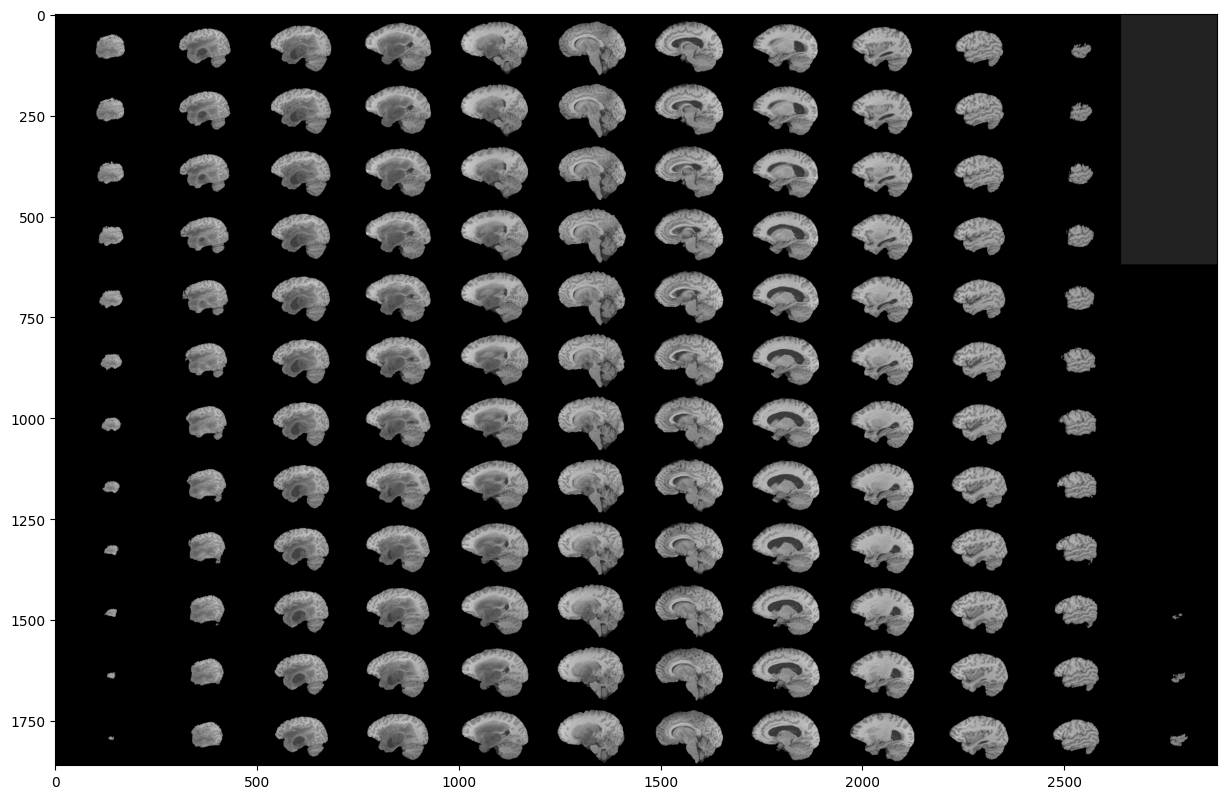

In [20]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_t1[50:-50,:,:]), 90, resize=True), cmap ='gray')
plt.savefig('./images/Data Exploration/Detection_Slice.png', dpi=400)

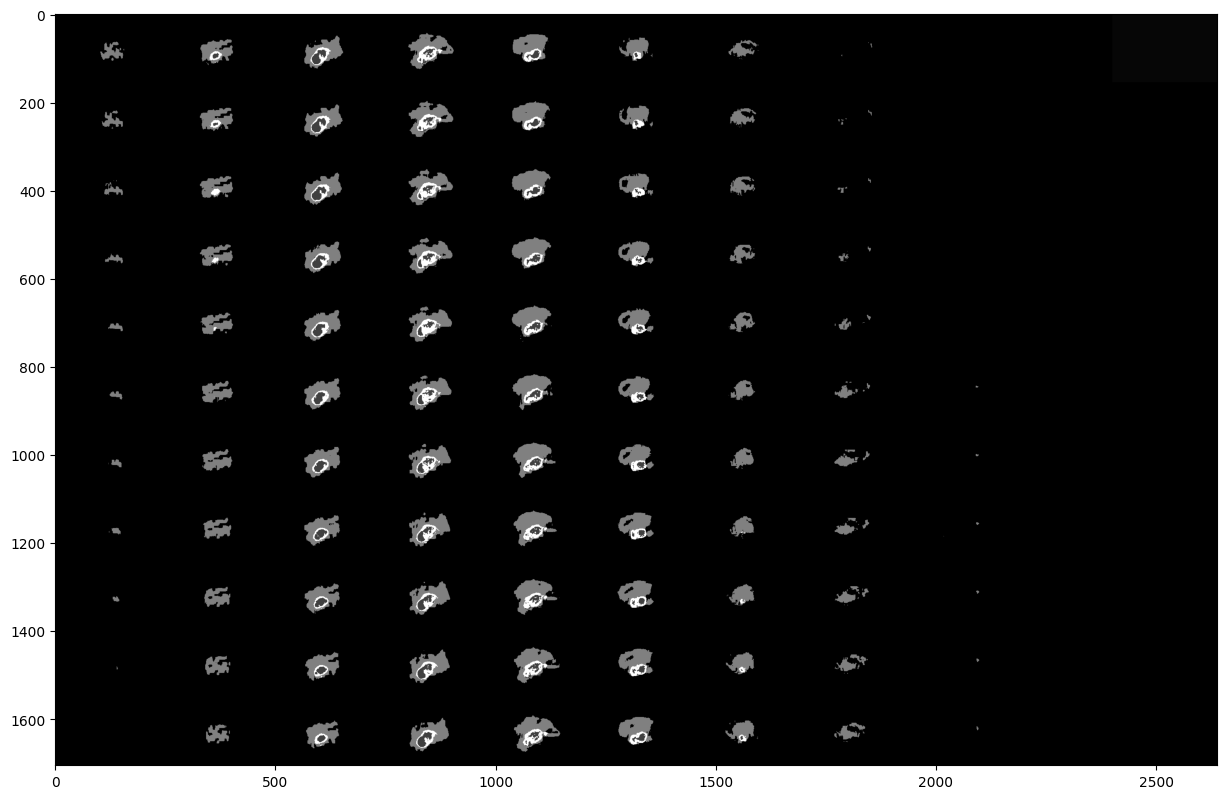

In [22]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_mask[50:-70,:,:]), 90, resize=True), cmap ='gray')
plt.savefig('./images/Data Exploration/DetectionMask_Slice.png', dpi=400)

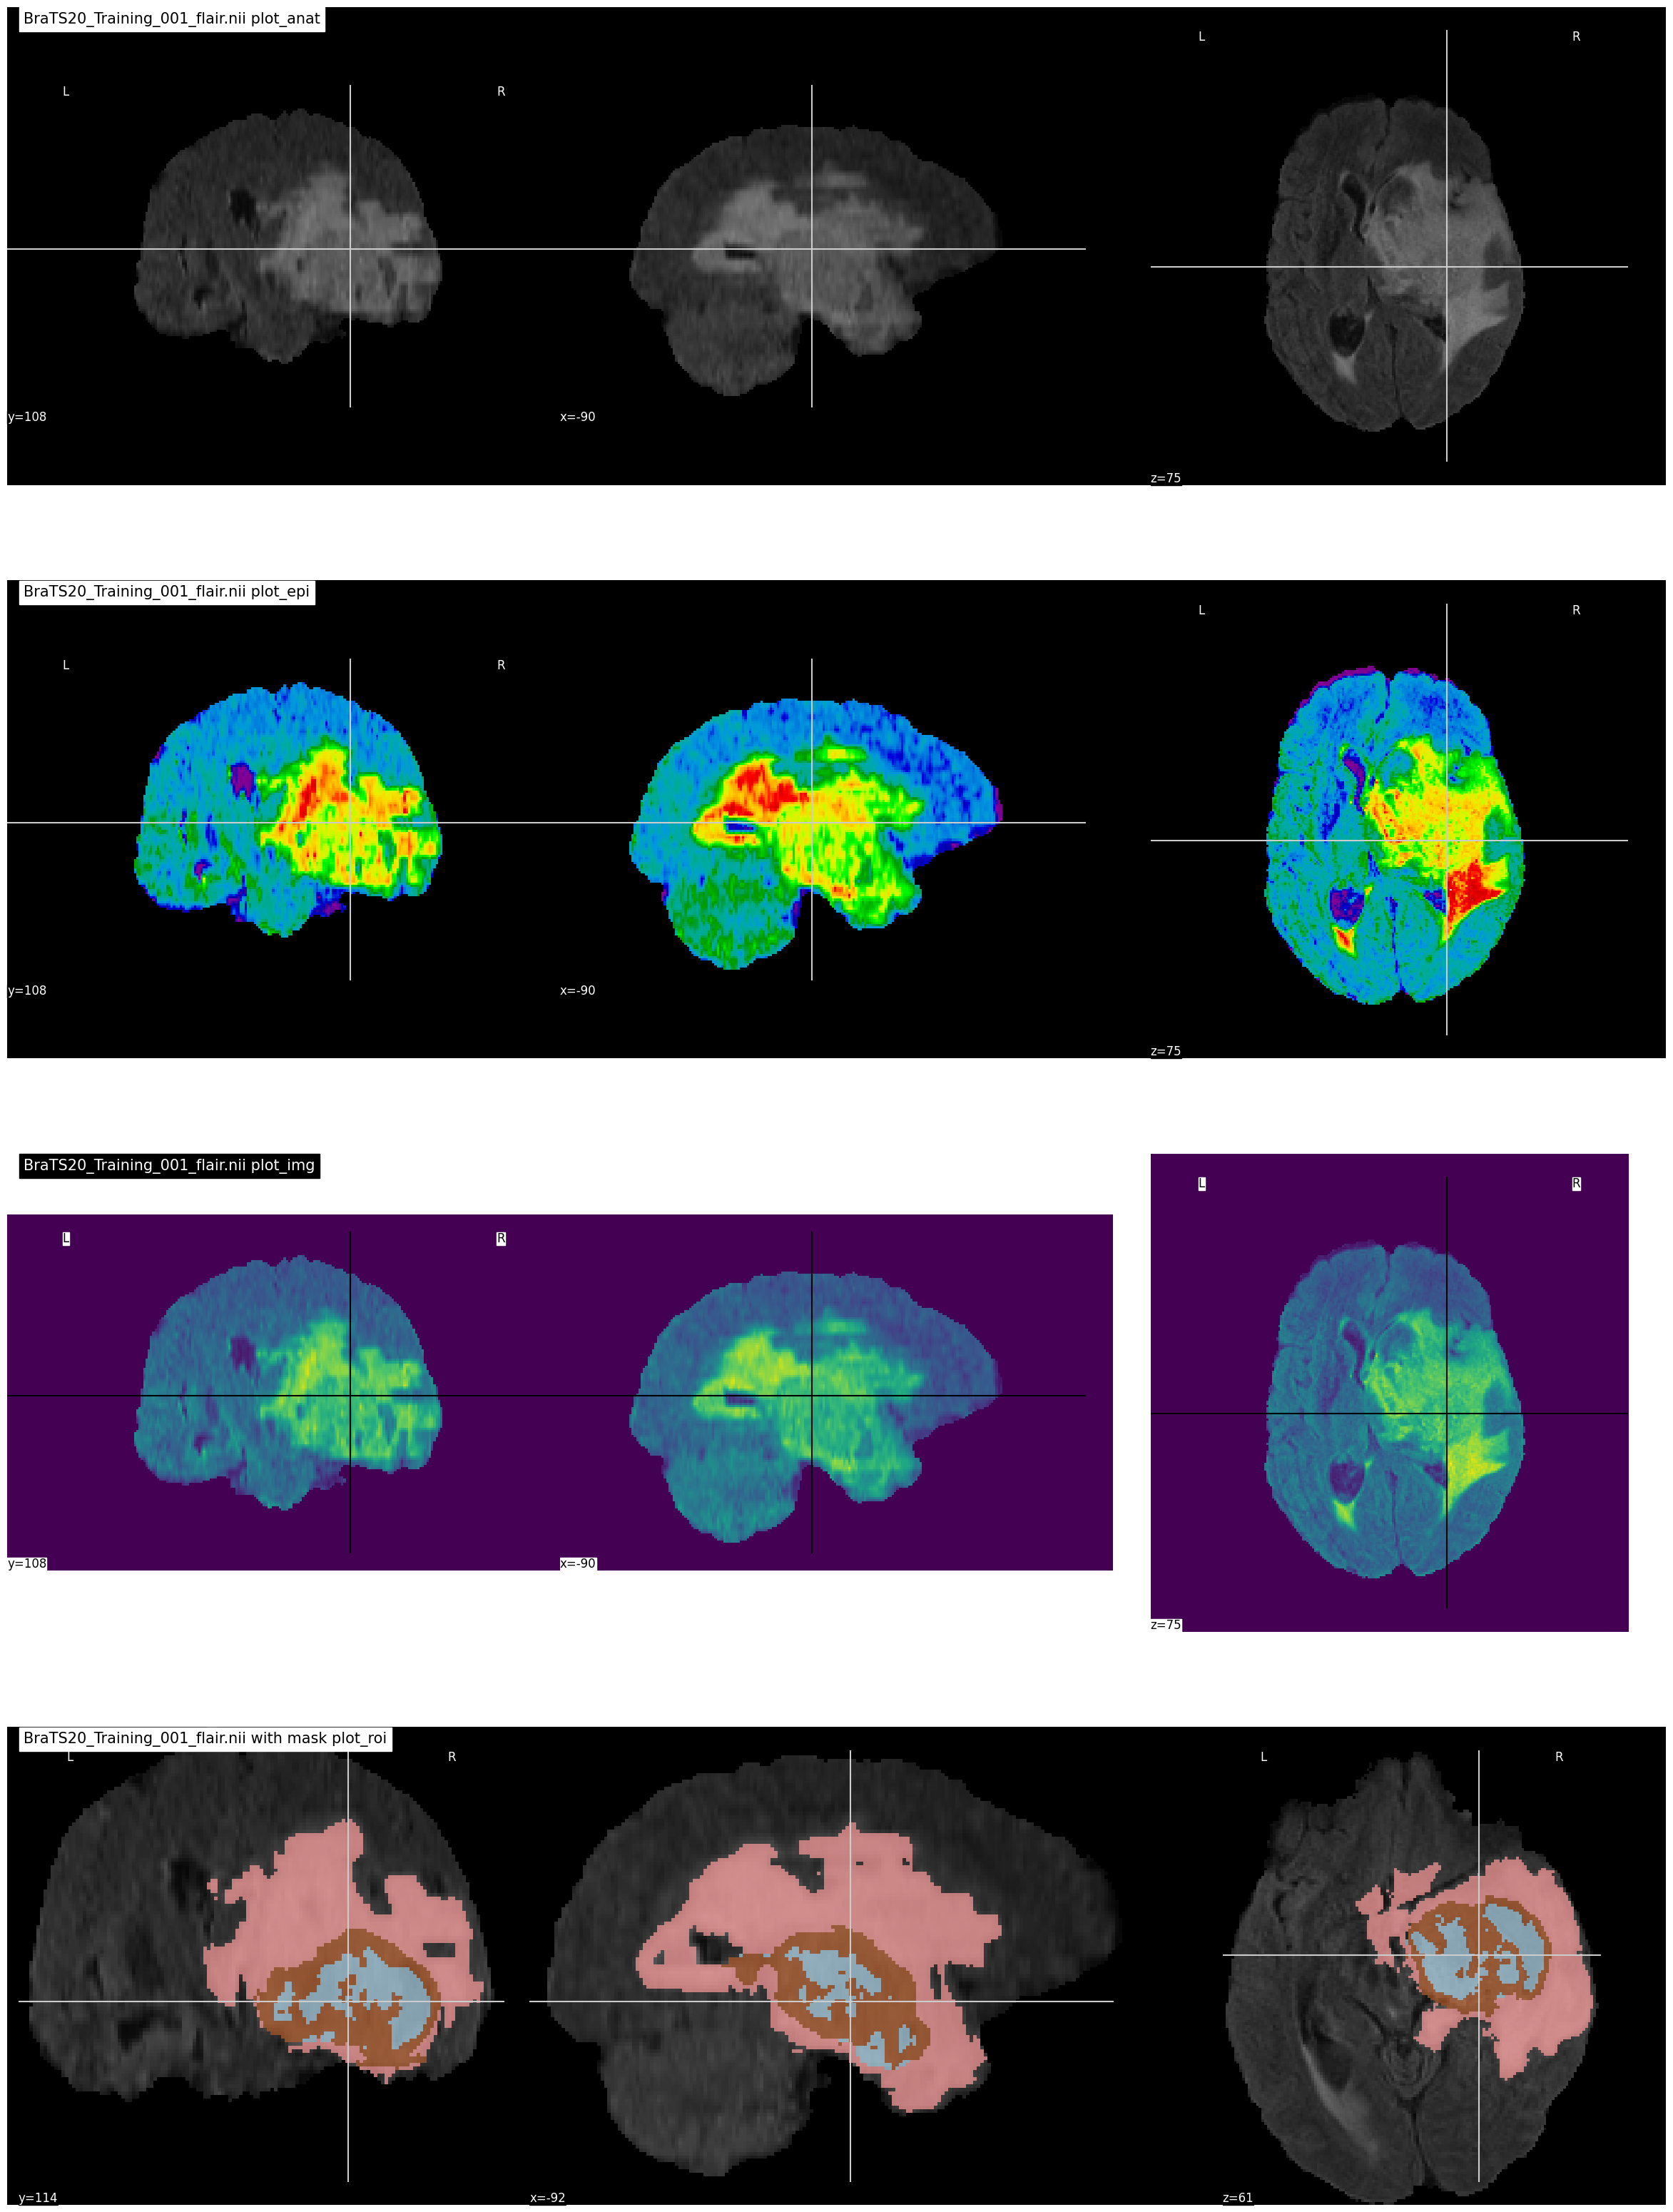

<Figure size 640x480 with 0 Axes>

In [23]:
niimg = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii')
nimask = nl.image.load_img(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii')

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


nlplt.plot_anat(niimg,
                title='BraTS20_Training_001_flair.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='BraTS20_Training_001_flair.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='BraTS20_Training_001_flair.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask, 
               title='BraTS20_Training_001_flair.nii with mask plot_roi',
               bg_img=niimg, 
               axes=axes[3], cmap='Paired')

plt.show()
plt.savefig('./images/Data Exploration/Detection_Anat.png', dpi=400)